# Example

At this point we're overloading Jupyter notebook as our front end since I'm the only one using this app

In [1]:
from itertools import product
from functools import partial
import pandas as pd
import satori

In [2]:
try:
    df = pd.read_csv("./example/EUR=X-simpleCleaned.csv")
except:
    # example of data:
    df = pd.DataFrame({
        'High': [
            0.837240,
            0.837100,
            0.828020,
            0.830290,
            0.828780,], 
        'Low': [
            0.830560,
            0.825830,
            0.824400,
            0.823450,
            0.820280,],
        'Close': [
            0.835770,
            0.827200,
            0.824880,
            0.827750,
            0.820550,],})
past = df.iloc[:round(df.shape[0]*.8)]
future = df.iloc[round(df.shape[0]*.8):]

In [3]:
def getNewData() -> pd.DataFrame:
    ''' incrementally returns mock future data to simulate the passage of time '''
    for i in future.index:
        yield pd.DataFrame(future.loc[i]).T

In [4]:
data = satori.DataManager(
        data=past,
        getData=partial(next, getNewData()),
        validateData=satori.DataManager.defaultValidateData,
        appendData=satori.DataManager.defaultAppend)

In [5]:
def generateCombinedFeature(df:pd.DataFrame=None, columns:'list(str)'=None, prefix='Diff') -> pd.DataFrame:
    '''
    example of making a feature out of data you know ahead of time.
    most of the time you don't know what kinds of data you'll get...
    '''
    def name() -> str:
        return f'{prefix}{columns[0]}{columns[1]}'

    if df is None:
        return name()

    columns = columns or []
    feature = df.loc[:, columns[0]] - df.loc[:, columns[1]]
    feature.name = name()
    return feature

In [6]:
kwargs = {
    'hyperParameters': [
        satori.HyperParameter(
            name='n_estimators',
            value=300,
            kind=int,
            limit=100,
            minimum=200,
            maximum=5000),
        satori.HyperParameter(
            name='learning_rate',
            value=0.3,
            kind=float,
            limit=.05,
            minimum=.01,
            maximum=.1),
        satori.HyperParameter(
            name='max_depth',
            value=6,
            kind=int,
            limit=1,
            minimum=10,
            maximum=2),],
    'metrics':  {
        # raw data features
        'raw': satori.ModelManager.rawDataMetric,
        # daily percentage change, 1 day ago, 2 days ago, 3 days ago... 
        **{f'Daily{i}': partial(satori.ModelManager.dailyPercentChangeMetric, yesterday=i) for i in list(range(1, 31))},
        # rolling period transformation percentage change, max of the last 7 days, etc... 
        **{f'Rolling{i}{tx[0:3]}': partial(satori.ModelManager.rollingPercentChangeMetric, window=i, transformation=tx)
            for tx, i in product('sum() max() min() mean() median() std()'.split(), list(range(2, 21)))},
        # rolling period transformation percentage change, max of the last 50 or 70 days, etc... 
        **{f'Rolling{i}{tx[0:3]}': partial(satori.ModelManager.rollingPercentChangeMetric, window=i, transformation=tx)
            for tx, i in product('sum() max() min() mean() median() std()'.split(), list(range(22, 90, 7)))}},
    'features': {'DiffHighLow': partial(generateCombinedFeature, columns=['High', 'Low'])},
    'chosenFeatures': ['RawClose', 'RawHigh', 'RawLow', 'DiffHighLow'],
    'override': True}

In [7]:
modelHigh = satori.ModelManager(
    modelPath='modelHigh.joblib',
    targetKey='High',
    pinnedFeatures=['DiffHighLow'],
    **kwargs)

In [8]:
modelLow = satori.ModelManager(
    modelPath='modelLow.joblib',
    targetKey='Low',
    **kwargs)

In [9]:
modelClose = satori.ModelManager(
    modelPath='modelClose.joblib',
    targetKey='Close',
    **kwargs)

In [10]:
learner = satori.Learner(
    cooldown=3,
    recess=3,
    view=satori.JupyterView(points=8),
    data=data,
    models={modelHigh, modelLow, modelClose})

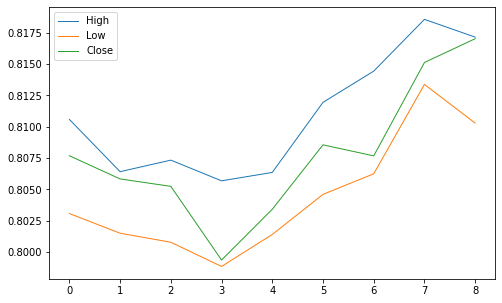

Predictions:

  Close: 0.8170164823532104
  Low: 0.8102819919586182
  High: 0.8171412944793701

Scores:

  Close: 0.946 (0.946)
  Low: 0.91 (0.942)
  High: 0.957 (-16.399)


In [11]:
learner.run(cooldown=0, recess=60)